# Classification of Documents

#### A couple of additional tools and basic imports to be used below

In [2]:
from __future__ import division, print_function

#General Imports
import pickle

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

In [3]:
#convert Unicode object to ASCII strings
from django.utils.encoding import smart_str, smart_unicode 
def convertU(data):
    if isinstance(data, basestring):
        return smart_str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convertU, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convertU, data))
    else:
        return data

### Connect to Database

In [3]:
from pymongo import MongoClient
# Connect to the mongo local database
connection = MongoClient()
db = connection.bsa_files
collection = db.bsa_files

### Classification Toolset

In [4]:
#full packages
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
import os
import codecs

#sklearn tools
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances 
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.externals import joblib

#nltk tools
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


#scipy tools
from scipy.cluster.hierarchy import ward, dendrogram

#gensim
from gensim import corpora, models, similarities 

C:\Users\ajwil\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
INFO : 'pattern' package found; tag filters are available for English


### Working file lists & dicts

In [5]:
working_uid_list =  pickle.load(open('working_uid_list.pickle','r'))
working_hash_dict = pickle.load(open('working_hash_dict.pickle','r'))
content_hash_dict = pickle.load(open('content_hash_dict.pickle','r'))
unique_content_hash_list = pickle.load(open('unique_content_hash_list.pickle','r'))

#Validate
print(len(working_uid_list))
print(len(working_hash_dict))
print(len(content_hash_dict))
print(len(unique_content_hash_list))

36549
5546
4221
4221


### Create Text Corpus

In [38]:
english_text_corpus = []
english_text_names = []
spanish_text_corpus = []
spanish_text_names = []

for unique_hash in unique_content_hash_list:
    document = collection.find_one({"Content_Hash":unique_hash})
    if document["Content"]!=None and len(document["Content"])>1:
        if document["Language"]=='english':
            english_text_corpus.append(document["Content"])
            english_text_names.append(document["File_Name"])
        elif document["Language"]=='spanish':
            spanish_text_corpus.append(document["Content"])
            spanish_text_names.append(document["File_Name"])

with open('bsa_english_corpus.pickle','w') as p:
    pickle.dump(english_text_corpus,p)
with open('bsa_spanish_corpus.pickle','w') as q:
    pickle.dump(spanish_text_corpus,q)
with open('bsa_english_document_names.pickle','w') as r:
    pickle.dump(english_text_names,r)
with open('bsa_spanish_document_names.pickle','w') as s:
    pickle.dump(spanish_text_names,s)

In [39]:
print("English Documents for Classification: {}".format(len(english_text_corpus)))
print("Spanish Documents for Classification: {}".format(len(spanish_text_corpus)))
print("English Documents Names: {}".format(len(english_text_names)))
print("Spanish Documents Names: {}".format(len(spanish_text_names)))

English Documents for Classification: 3979
Spanish Documents for Classification: 240
English Documents Names: 3979
Spanish Documents Names: 240


In [5]:
english_text_corpus = pickle.load(open('bsa_english_corpus.pickle','r'))
spanish_text_corpus = pickle.load(open('bsa_spanish_corpus.pickle','r'))
english_text_names = pickle.load(open('bsa_english_document_names.pickle','r'))
spanish_text_names = pickle.load(open('bsa_spanish_document_names.pickle','r'))

# Process Text Corpus
    Remove Stopwords, punctuations and stem

### Stopwords, Stemming and Tokenizer

In [9]:
#special stopwords to remove common scouting terms and other erroneous text that continually showed up in the results
bsa_stop_words = ['scout','boy','cub','train','council',
                  'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

english_stopwords = stopwords.words('english') + bsa_stop_words
spanish_stopwords = stopwords.words('spanish') + bsa_stop_words + stopwords.words('english')

english_stemmer = SnowballStemmer("english")
spanish_stemmer = SnowballStemmer("spanish")

def tokenize_and_stem_english(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [english_stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_stem_spanish(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [spanish_stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



### Implement stemming and tokenizing

In [43]:
english_vocab_stemmed = []
english_vocab_tokenized = []
spanish_vocab_stemmed = []
spanish_vocab_tokenized = []

for e in english_text_corpus:
    words_stemmed = tokenize_and_stem_english(e)
    english_vocab_stemmed.extend(words_stemmed)
    words_tokenized = tokenize_only(e)
    english_vocab_tokenized.extend(words_tokenized)

for s in spanish_text_corpus:
    words_stemmed = tokenize_and_stem_spanish(s)
    spanish_vocab_stemmed.extend(words_stemmed)
    words_tokenized = tokenize_only(s)
    spanish_vocab_tokenized.extend(words_tokenized)
    
with open('english_vocab_stemmed.pickle','w') as p:
    pickle.dump(english_vocab_stemmed,p)
with open('english_vocab_tokenized.pickle','w') as q:
    pickle.dump(english_vocab_tokenized,q)
with open('spanish_vocab_stemmed.pickle','w') as r:
    pickle.dump(spanish_vocab_stemmed,r)
with open('spanish_vocab_tokenized.pickle','w') as s:
    pickle.dump(spanish_vocab_tokenized,s)

### Initialize Dataframes

In [44]:
english_vocab_frame = pd.DataFrame({'words':english_vocab_tokenized}, index = english_vocab_stemmed)
print('There are {} items in english_vocab_frame'.format(str(english_vocab_frame.shape[0])))

spanish_vocab_frame = pd.DataFrame({'words':spanish_vocab_tokenized}, index = spanish_vocab_stemmed)
print('There are {} items in spanish_vocab_frame'.format(str(spanish_vocab_frame.shape[0])))

with open('english_vocab_frame.pickle','w') as p:
    pickle.dump(english_vocab_frame,p)
with open('spanish_vocab_frame.pickle','w') as q:
    pickle.dump(spanish_vocab_frame,q)

There are 10947405 items in english_vocab_frame
There are 1986384 items in spanish_vocab_frame


In [45]:
english_vocab_frame = pickle.load(open('english_vocab_frame.pickle','r'))
spanish_vocab_frame = pickle.load(open('spanish_vocab_frame.pickle','r'))

### TF-IDF Vectorization

In [46]:
english_tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                           max_features=200000,
                                           min_df=0.2, 
                                           stop_words=english_stopwords,
                                           use_idf=True, 
                                           tokenizer=tokenize_and_stem_english, 
                                           ngram_range=(1,3))

spanish_tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                           max_features=200000,
                                           min_df=0.2, 
                                           stop_words=spanish_stopwords,
                                           use_idf=True, 
                                           tokenizer=tokenize_and_stem_spanish, 
                                           ngram_range=(1,3))

english_tfidf_matrix = english_tfidf_vectorizer.fit_transform(english_text_corpus)
print(english_tfidf_matrix.shape)

spanish_tfidf_matrix = spanish_tfidf_vectorizer.fit_transform(spanish_text_corpus)
print(spanish_tfidf_matrix.shape)

(3979, 313)
(240, 790)


In [47]:
english_terms = english_tfidf_vectorizer.get_feature_names()
spanish_terms = spanish_tfidf_vectorizer.get_feature_names()

In [48]:
english_dist = 1-cosine_similarity(english_tfidf_matrix)
spanish_dist = 1-cosine_similarity(spanish_tfidf_matrix)

In [49]:
with open('english_tfidf_matrix.pickle','w') as a:
    pickle.dump(english_tfidf_matrix,a)
with open('spanish_tfidf_matrix.pickle','w') as b:
    pickle.dump(spanish_tfidf_matrix,b)
with open('english_terms.pickle','w') as c:
    pickle.dump(english_terms,c)
with open('spanish_terms.pickle','w') as d:
    pickle.dump(spanish_terms,d)
with open('english_dist.pickle','w') as e:
    pickle.dump(english_dist,e)
with open('spanish_dist.pickle','w') as f:
    pickle.dump(spanish_dist,f)

### Re-load data to start at classification

In [5]:
english_tfidf_matrix = pickle.load(open('english_tfidf_matrix.pickle','r'))
spanish_tfidf_matrix = pickle.load(open('spanish_tfidf_matrix.pickle','r'))

english_terms = pickle.load(open('english_terms.pickle','r'))
spanish_terms = pickle.load(open('spanish_terms.pickle','r'))

english_dist = pickle.load(open('english_dist.pickle','r'))
spanish_dist = pickle.load(open('spanish_dist.pickle','r'))

english_text_names = pickle.load(open('bsa_english_document_names.pickle','r'))
spanish_text_names = pickle.load(open('bsa_spanish_document_names.pickle','r'))

english_text_corpus = pickle.load(open('bsa_english_corpus.pickle','r'))
spanish_text_corpus = pickle.load(open('bsa_spanish_corpus.pickle','r'))

english_vocab_frame = pickle.load(open('english_vocab_frame.pickle','r'))
spanish_vocab_frame = pickle.load(open('spanish_vocab_frame.pickle','r'))

### K-Means Classification / Clustering

In [9]:
num_english_clusters = 6
num_spanish_clusters = 4

english_km = KMeans(n_clusters = num_english_clusters)
spanish_km = KMeans(n_clusters = num_spanish_clusters)

english_km.fit(english_tfidf_matrix)
spanish_km.fit(spanish_tfidf_matrix)

english_clusters = english_km.labels_.tolist()
spanish_clusters = spanish_km.labels_.tolist()

joblib.dump(english_km, 'english_km.pkl')
joblib.dump(spanish_km, 'spanish_km.pkl')

['spanish_km.pkl', 'spanish_km.pkl_01.npy', 'spanish_km.pkl_02.npy']

In [10]:
english_km = joblib.load('english_km.pkl')
spanish_km = joblib.load('spanish_km.pkl')

english_clusters = english_km.labels_.tolist()
spanish_clusters = spanish_km.labels_.tolist()

In [11]:
english_documents = {'name':english_text_names,
                    'text':english_text_corpus,
                    'cluster':english_clusters}
spanish_documents = {'name':spanish_text_names,
                    'text':spanish_text_corpus,
                    'cluster':spanish_clusters}

english_df =pd.DataFrame(english_documents, 
                         index = [english_clusters], 
                         columns = ['name','text','cluster'])

spanish_df =pd.DataFrame(spanish_documents, 
                         index = [spanish_clusters], 
                         columns = ['name','text','cluster'])

### Identify Clusters by keywords

In [12]:
from __future__ import print_function

print("Top Terms per English Cluster")
print()

order_centroids = english_km.cluster_centers_.argsort()[:, ::-1] 

for i in range (num_english_clusters):
    
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % english_vocab_frame.ix[english_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    
    print("Cluster %d Size:" % i, end='')
    print(len(english_df.ix[i]['name'].values.tolist()))
    #for name in english_df.ix[i]['name'].values.tolist():
        #print(' %s,' % name, end='')
    print()
    print()

Top Terms per English Cluster

Cluster 0 words: dates, name, badge, report, camp, required,

Cluster 0 Size:1339


Cluster 1 words: meeting, one, active, times, using, help,

Cluster 1 Size:701


Cluster 2 words: units, district, service, tools, organizing, program,

Cluster 2 Size:388


Cluster 3 words: adventure, bases, building, take, started, opportunity,

Cluster 3 Size:167


Cluster 4 words: http, website, merit, badge, explain, following,

Cluster 4 Size:198


Cluster 5 words: program, national, youth, camp, awards, service,

Cluster 5 Size:1186




In [13]:
print("Top Terms per Spanish Cluster")
print()

order_centroids = spanish_km.cluster_centers_.argsort()[:, ::-1] 

for i in range (num_spanish_clusters):
    
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % spanish_vocab_frame.ix[spanish_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    
    print("Cluster %d Size:" % i, end='')
    print(len(spanish_df.ix[i]['name'].values.tolist()))
    #for name in spanish_df.ix[i]['name'].values.tolist():
    #    print(' %s,' % name, end='')
    print()
    print()

Top Terms per Spanish Cluster

Cluster 0 words: venturers, major, parte, recorrido, saben, seunscout.org,

Cluster 0 Size:32


Cluster 1 words: scouting, program, scouts, cómo, pueda, debe,

Cluster 1 Size:98


Cluster 2 words: seunscout.org, para, based, aventura, based, gran,

Cluster 2 Size:68


Cluster 3 words: den, jugadores, pack, niños, minute, juego,

Cluster 3 Size:42




In [ ]:
-

### Graph Clusters

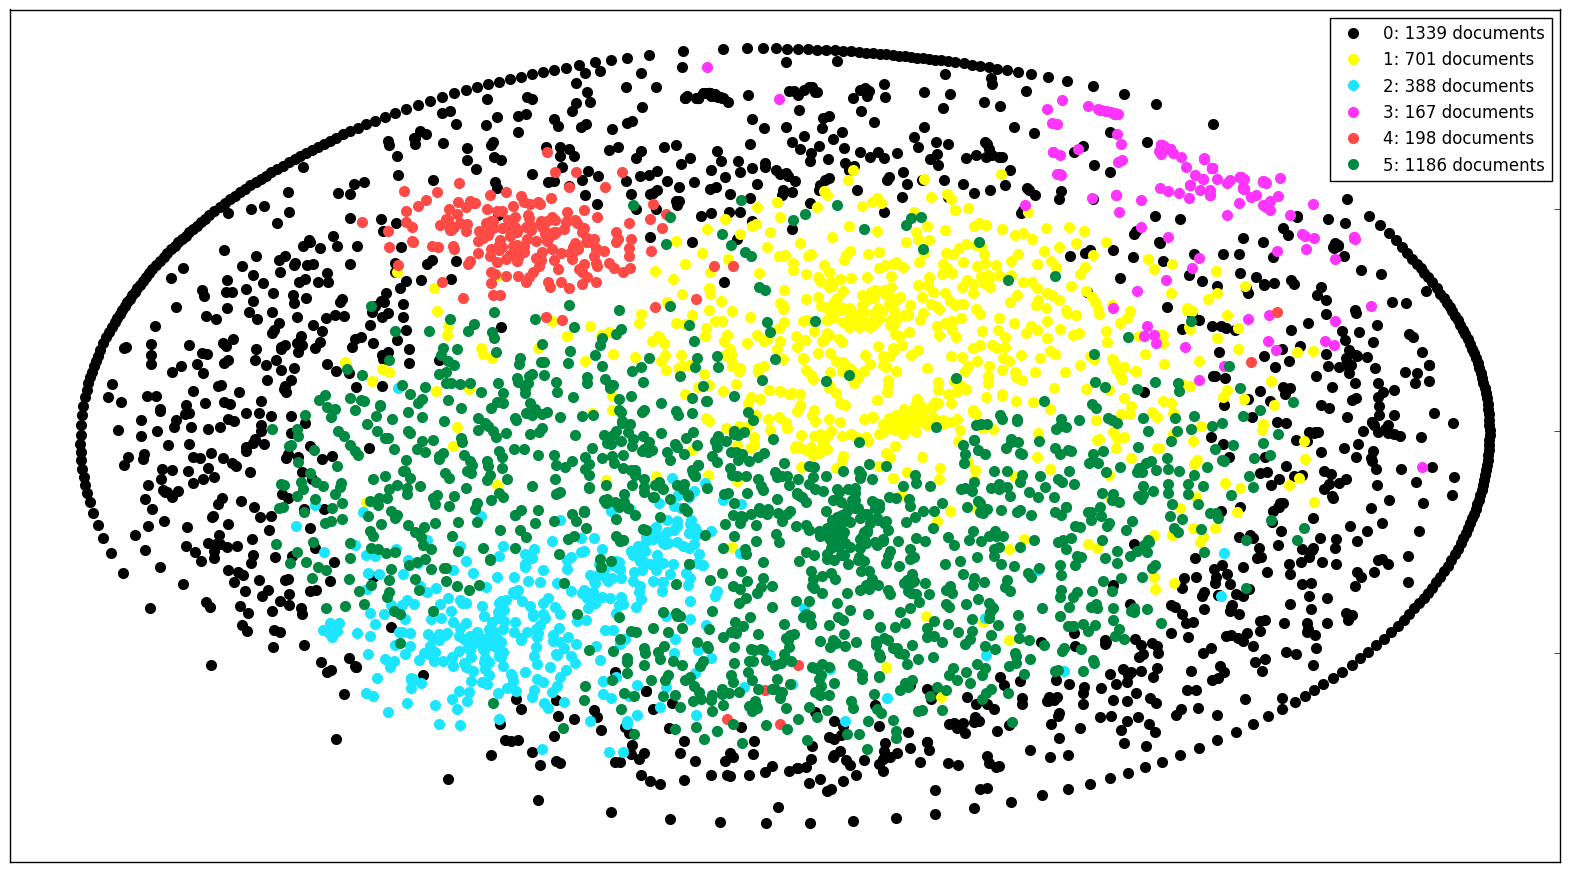

In [14]:
MDS()

mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state=1)

pos = mds.fit_transform(english_dist)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: "#000000",
                 1: "#FFFF00",
                 2: "#1CE6FF",
                 3: "#FF34FF",
                 4: "#FF4A46",
                 5: "#008941"}

cluster_names = {0: '0: {} documents'.format((len(english_df.ix[0]['name'].values.tolist()))),
                 1: '1: {} documents'.format((len(english_df.ix[1]['name'].values.tolist()))),
                 2: '2: {} documents'.format((len(english_df.ix[2]['name'].values.tolist()))), 
                 3: '3: {} documents'.format((len(english_df.ix[3]['name'].values.tolist()))),
                 4: '4: {} documents'.format((len(english_df.ix[4]['name'].values.tolist()))),
                 5: '5: {} documents'.format((len(english_df.ix[5]['name'].values.tolist())))}


df = pd.DataFrame(dict(x=xs, y=ys, label=english_clusters, name=english_text_names)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 11)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point    
    
plt.show()

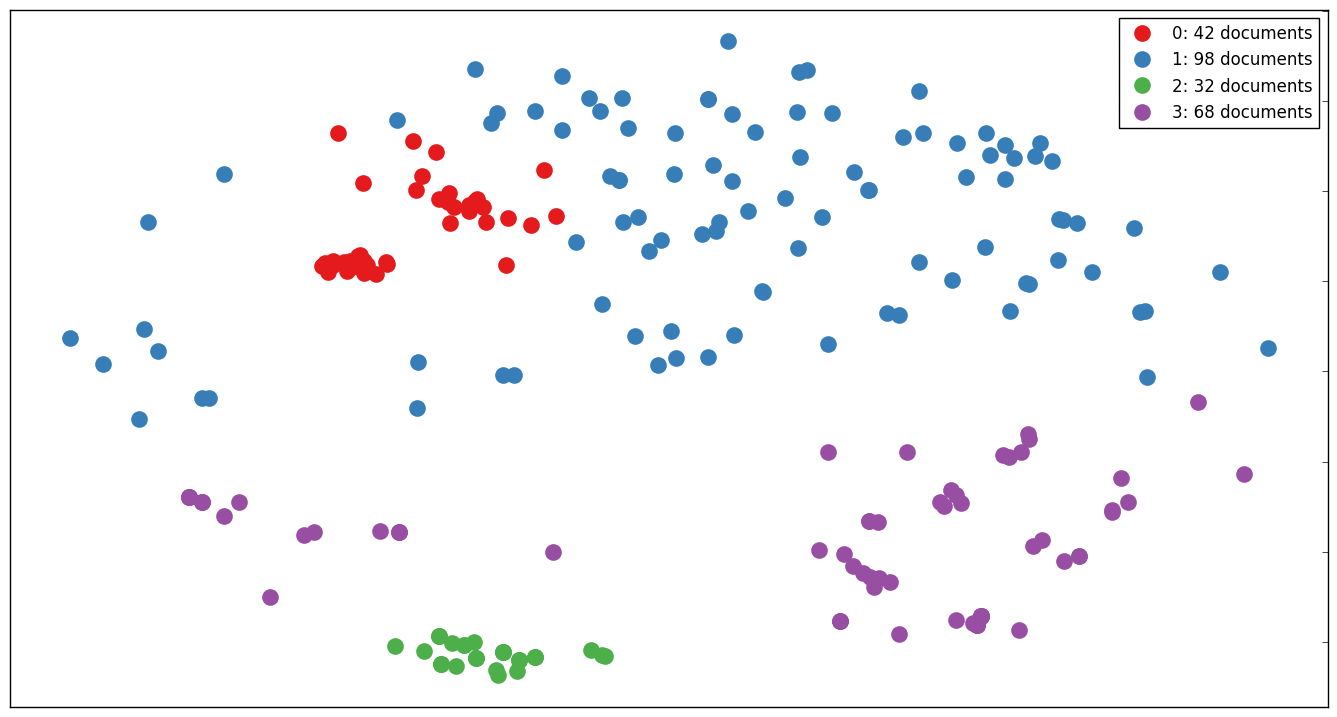

In [24]:
MDS()

mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state=1)

pos = mds.fit_transform(spanish_dist)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#e41a1c',
                 1: '#377eb8',
                 2: '#4daf4a',
                 3: '#984ea3'}

cluster_names = {0: '0: {} documents'.format((len(spanish_df.ix[0]['name'].values.tolist()))),
                 1: '1: {} documents'.format((len(spanish_df.ix[1]['name'].values.tolist()))),
                 2: '2: {} documents'.format((len(spanish_df.ix[2]['name'].values.tolist()))), 
                 3: '3: {} documents'.format((len(spanish_df.ix[3]['name'].values.tolist())))}

df = pd.DataFrame(dict(x=xs, y=ys, label=spanish_clusters, name=spanish_text_names)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point   
    
plt.show()

### Hierarchical Clustering

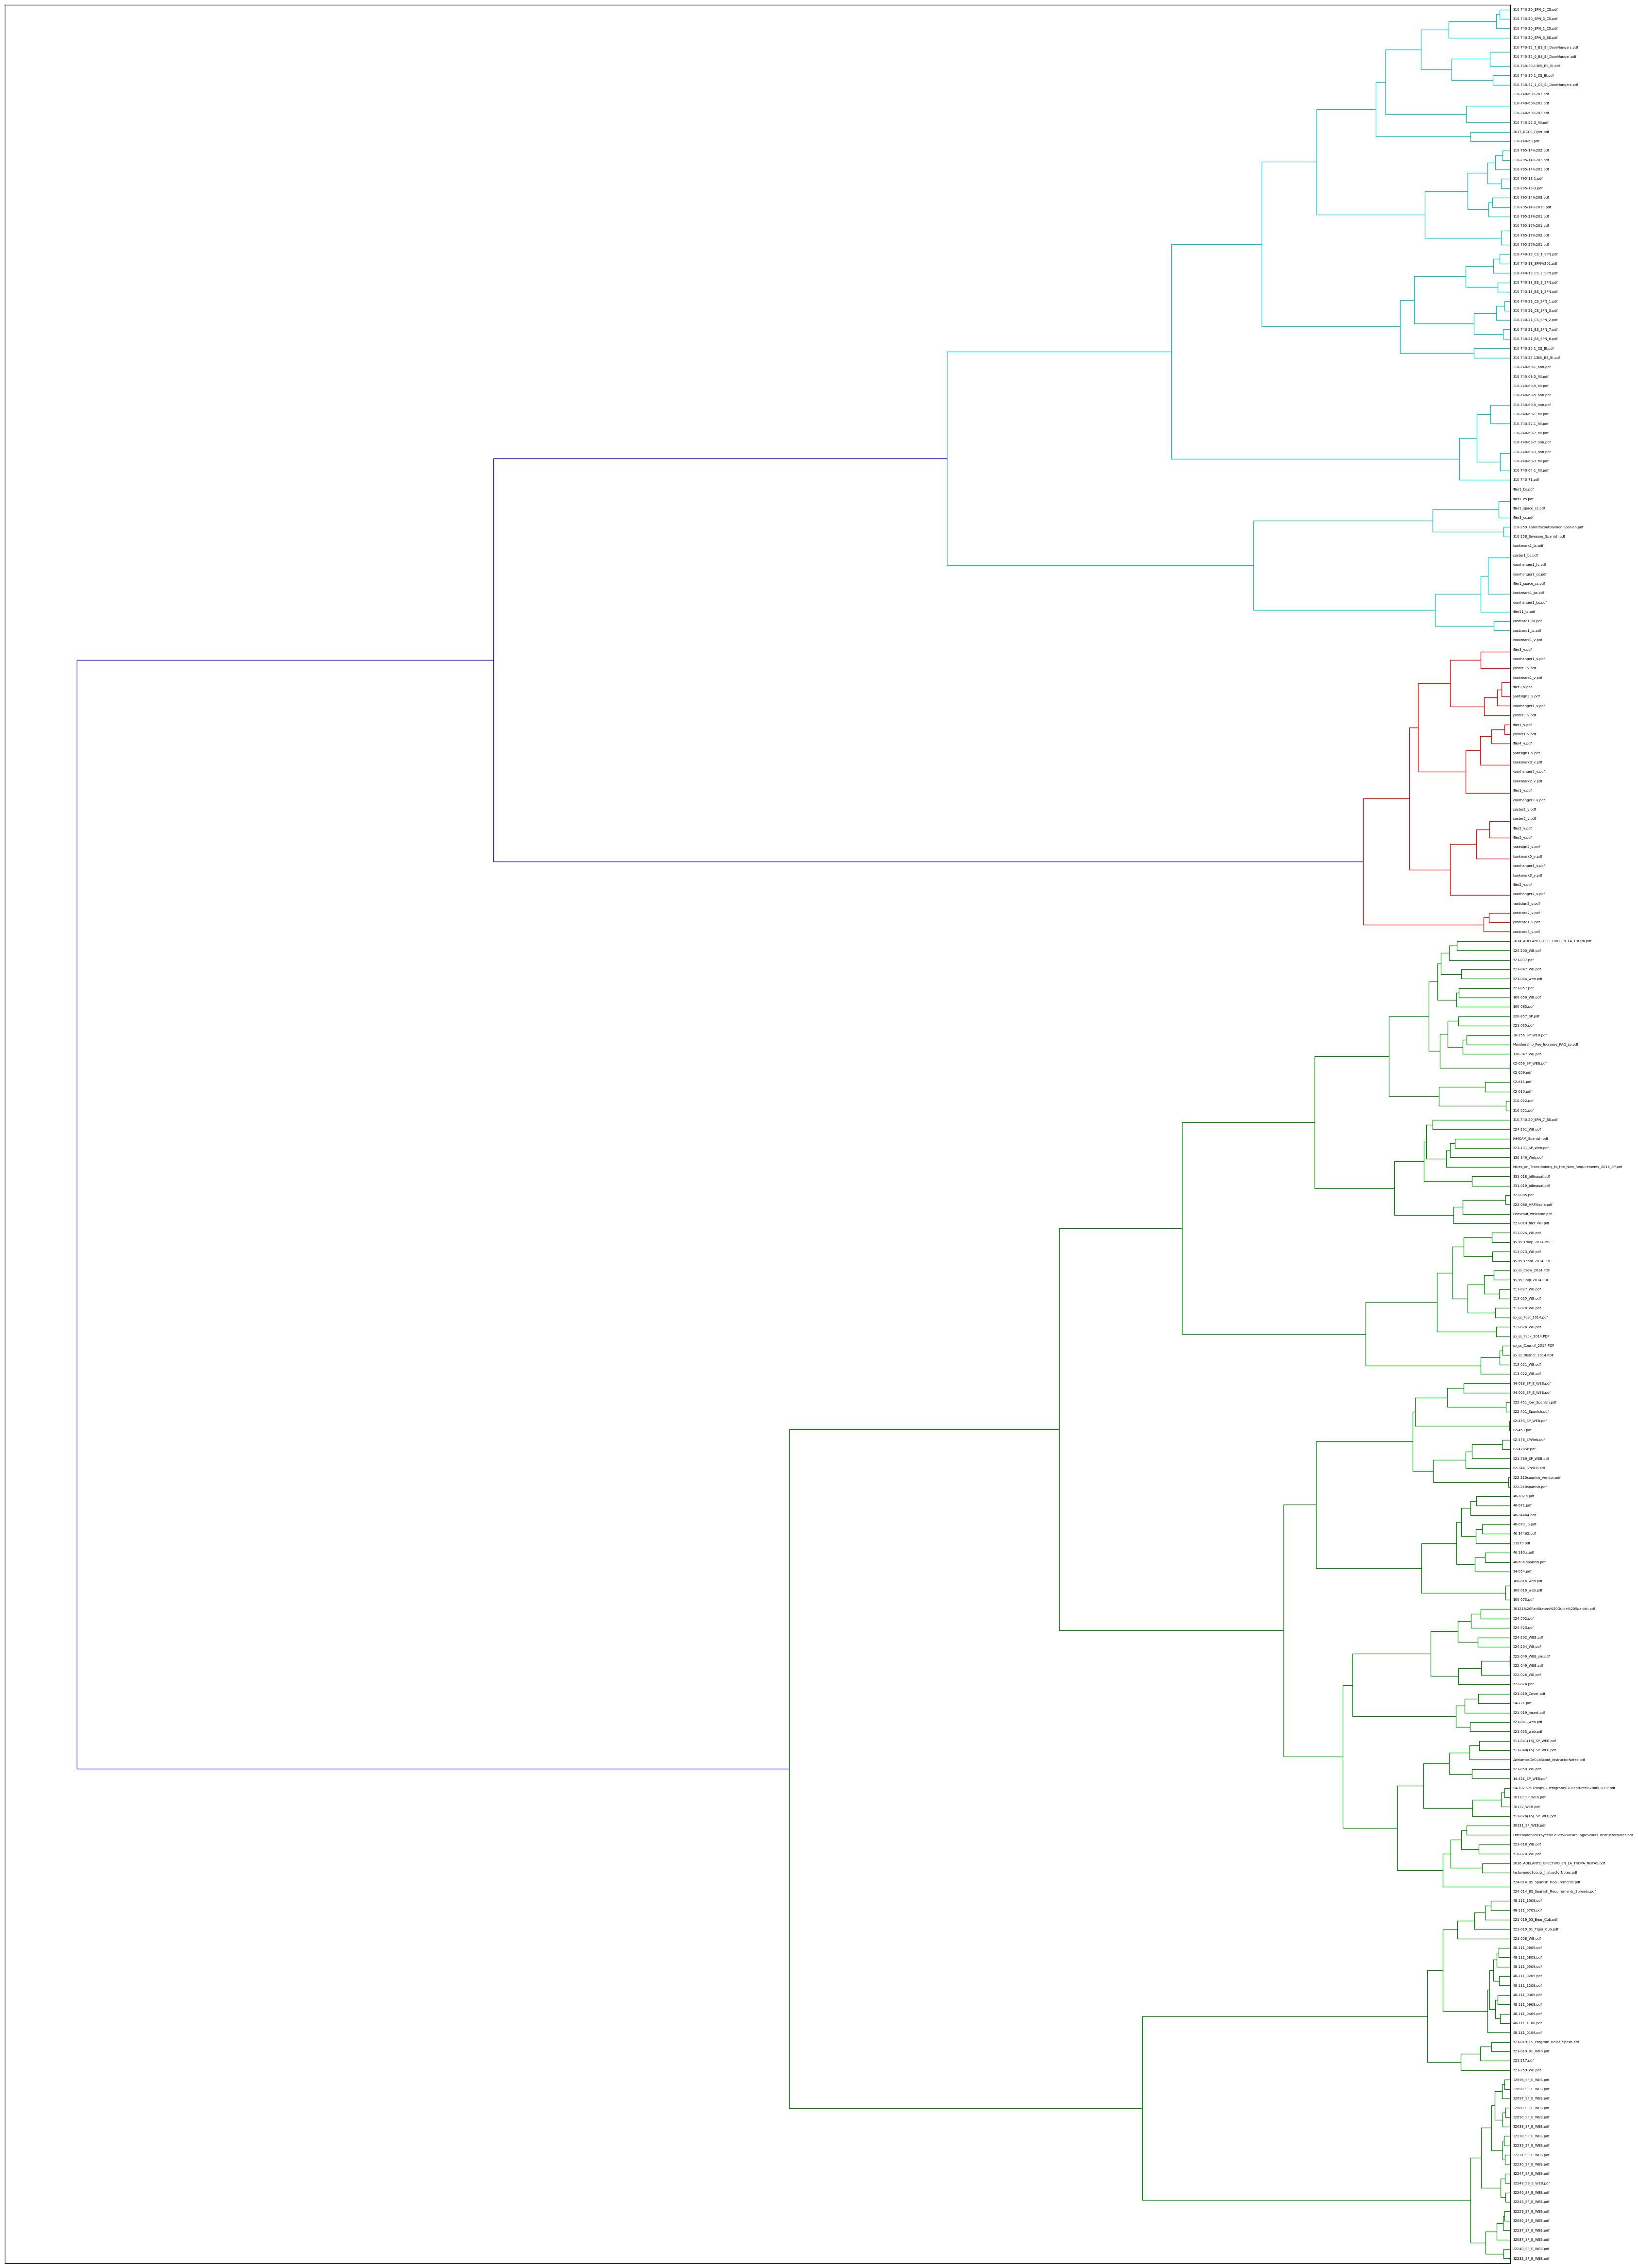

In [30]:
linkage_matrix = ward(spanish_dist)

fig, ax = plt.subplots(figsize = (40,60))
ax = dendrogram(linkage_matrix, orientation="left", labels=spanish_text_names);

plt.tick_params(axis = 'x', which='both', bottom='off', top='off', labelbottom='off')

#plt.tight_layout()

plt.savefig('Spanish_Ward_Clusters.png', dpi = 200)
plt.show()

In [16]:
plt.close()

### Latent Dirichlet Allocation

In [53]:
def my_LDA(texts, num_topics):
    
    p = string.punctuation
    table_p = string.maketrans(p, len(p) * " ")
    d = string.digits
    table_d = string.maketrans(d, len(d) * " ")
    
    docs = []
    for d in texts:
        temp = convertU(d).lower().translate(table_p).translate(table_d).strip().split()
        for word in temp:
            if word in spanish_stopwords:
                temp.remove(word)
        docs.append(temp)

    dic = corpora.Dictionary(docs)
    print(dic)
    
    corpus = [dic.doc2bow(text) for text in docs]
    print(type(corpus), len(corpus))
    
    tfidf = models.TfidfModel(corpus)
    print(type(tfidf))
    
    corpus_tfidf = tfidf[corpus]
    print(type(corpus_tfidf))
    
    NUM_TOPICS = num_topics
    model = models.ldamodel.LdaModel(corpus_tfidf, num_topics=NUM_TOPICS, 
                                     id2word=dic, 
                                     update_every=1, 
                                     passes=50)
    
    print("LDA model")
    topics_found = model.print_topics(20)
    counter = 1
    for t in topics_found:
        print("Topic #{} {}".format(counter, t))
        counter += 1

In [55]:
my_LDA(spanish_text_corpus,4)

C:\Users\ajwil\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(50713 unique tokens: [u'cantidadpagada', u'\u201dstas', u'wolftie', u'woods', u'ecipiente']...) from 240 documents (total 1357468 corpus positions)


Dictionary(50713 unique tokens: [u'cantidadpagada', u'\u201dstas', u'wolftie', u'woods', u'ecipiente']...)


INFO : collecting document frequencies
INFO : PROGRESS: processing document #0
INFO : calculating IDF weights for 240 documents and 50712 features (286826 matrix non-zeros)
INFO : using symmetric alpha at 0.25
INFO : using symmetric eta at 0.25
INFO : using serial LDA version on this node


(<type 'list'>, 240)
<class 'gensim.models.tfidfmodel.TfidfModel'>
<class 'gensim.interfaces.TransformedCorpus'>


INFO : running online LDA training, 4 topics, 50 passes over the supplied corpus of 240 documents, updating model once every 240 documents, evaluating perplexity every 240 documents, iterating 50x with a convergence threshold of 0.001000
INFO : -182.505 per-word bound, 8696390430458837666565419354935100418197707193552207872.0 perplexity estimate based on a held-out corpus of 240 documents with 3171 words
INFO : PROGRESS: pass 0, at document #240/240
INFO : topic #0 (0.250): 0.000*"los" + 0.000*"sel˜es" + 0.000*"den" + 0.000*"build" + 0.000*"aquÍ" + 0.000*"the" + 0.000*"take" + 0.000*"seunscout" + 0.000*"amistades" + 0.000*"sobresalir"
INFO : topic #1 (0.250): 0.000*"los" + 0.000*"the" + 0.000*"la" + 0.000*"sobresalir" + 0.000*"pack" + 0.000*"el" + 0.000*"den" + 0.000*"scouts" + 0.000*"ball" + 0.000*"que"
INFO : topic #2 (0.250): 0.001*"venturers" + 0.001*"tuyo" + 0.000*"major" + 0.000*"recorrido" + 0.000*"saben" + 0.000*"the" + 0.000*"social" + 0.000*"riendas" + 0.000*"seunscout" + 0.0

LDA model
Topic #1 (0, u'0.000*"sel\u02dces" + 0.000*"sobresalir" + 0.000*"aqu\xcd" + 0.000*"seunscout" + 0.000*"amistades" + 0.000*"build" + 0.000*"listos" + 0.000*"futuro" + 0.000*"ampl\xeda" + 0.000*"convive"')
Topic #2 (1, u'0.000*"ecuador" + 0.000*"r" + 0.000*"jamcam" + 0.000*"yourbadge" + 0.000*"la" + 0.000*"vida" + 0.000*"el" + 0.000*"org" + 0.000*"conference" + 0.000*"obt\xc9n"')
Topic #3 (2, u'0.001*"venturers" + 0.001*"tuyo" + 0.001*"major" + 0.000*"recorrido" + 0.000*"saben" + 0.000*"bes" + 0.000*"riendas" + 0.000*"seunscout" + 0.000*"social" + 0.000*"\xe9xito"')
Topic #4 (3, u'0.001*"los" + 0.001*"the" + 0.001*"den" + 0.001*"pack" + 0.001*"la" + 0.000*"scouting" + 0.000*"ni\xf1os" + 0.000*"el" + 0.000*"scout" + 0.000*"que"')


In [54]:
my_LDA(english_text_corpus, 6)

C:\Users\ajwil\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(222512 unique tokens: [u'\ufb01designed\ufb02', u'\u02dc\u02da\u02db\u02db\u02db\u201c\u02db\u02d9\u02da\u02db\u02d9\u201c\u02c7', u'ecipients', u'theparticipantwillparticipateinonthejobtrainingwiththeirstaffleaderorexploring', u'program\u0152code']...) from 3979 documents (total 8211180 corpus positions)


Dictionary(222512 unique tokens: [u'\ufb01designed\ufb02', u'\u02dc\u02da\u02db\u02db\u02db\u201c\u02db\u02d9\u02da\u02db\u02d9\u201c\u02c7', u'ecipients', u'theparticipantwillparticipateinonthejobtrainingwiththeirstaffleaderorexploring', u'program\u0152code']...)


INFO : collecting document frequencies
INFO : PROGRESS: processing document #0


(<type 'list'>, 3979)


INFO : calculating IDF weights for 3979 documents and 222511 features (2261130 matrix non-zeros)
INFO : using symmetric alpha at 0.166666666667
INFO : using symmetric eta at 0.166666666667
INFO : using serial LDA version on this node


<class 'gensim.models.tfidfmodel.TfidfModel'>
<class 'gensim.interfaces.TransformedCorpus'>


INFO : running online LDA training, 6 topics, 50 passes over the supplied corpus of 3979 documents, updating model once every 2000 documents, evaluating perplexity every 3979 documents, iterating 50x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #2000/3979
INFO : merging changes from 2000 documents into a model of 3979 documents
INFO : topic #5 (0.167): 0.001*"the" + 0.000*"lodge" + 0.000*"advancement" + 0.000*"unit" + 0.000*"a" + 0.000*"oa" + 0.000*"commissioner" + 0.000*"scouts" + 0.000*"philmont" + 0.000*"eagle"
INFO : topic #3 (0.167): 0.001*"commissioner" + 0.001*"the" + 0.000*"beascout" + 0.000*"commissioners" + 0.000*"unit" + 0.000*"Ł" + 0.000*"lodge" + 0.000*"a" + 0.000*"adventure" + 0.000*"oa"
INFO : topic #0 (0.167): 0.001*"ˆ" + 0.001*"the" + 0.001*"˘" + 0.001*"ˇ" + 0.000*"˙" + 0.000*"unit" + 0.000*"˛" + 0.000*"commissioner" + 0.000*"oa" + 0.000*"a"
INFO : topic #2 (0.167): 0.001*"the" + 0.000*"beascout" + 0.000*"indd" + 0.000*"advancement" + 0

LDA model
Topic #1 (0, u'0.002*"the" + 0.001*"commissioner" + 0.001*"unit" + 0.001*"a" + 0.001*"lodge" + 0.001*"\u0141" + 0.001*"scouting" + 0.001*"oa" + 0.001*"camp" + 0.001*"program"')
Topic #2 (1, u'0.000*"jamboree\u02dcon\u02dcthe\u02dcairoctober" + 0.000*"jamboree\u02dcon\u02dcthe\u02dcair" + 0.000*"utc" + 0.000*"anvisionreport" + 0.000*"\u0192\u02d9" + 0.000*"\u02d9\xa5\xa5\xa5\xa5\xa5\xa5\xa5\xa5\xa5" + 0.000*"commissionercub" + 0.000*"yesyes" + 0.000*"toconnecttothewebconference" + 0.000*"usergroup"')
Topic #3 (2, u'0.000*"seunscout" + 0.000*"yourbadge" + 0.000*"indd" + 0.000*"beascout" + 0.000*"futuro" + 0.000*"pm" + 0.000*"scoutingjoin" + 0.000*"construirun" + 0.000*"el" + 0.000*"gran"')
Topic #4 (3, u'0.000*"completiondate" + 0.000*"\u0141bbec" + 0.000*"\u0152pas" + 0.000*"yourbeascout" + 0.000*"newconcept" + 0.000*"themoney" + 0.000*"\u0141constituent" + 0.000*"tobsa" + 0.000*"constituent" + 0.000*"definitions"')
Topic #5 (4, u'0.000*"seunscout" + 0.000*"gran" + 0.000*"futu